Code sourced from: https://github.com/amuguruza/NN-StochVol-Calibrations

In [7]:
import numpy as np
import keras
from keras.layers import Activation
from keras import backend as k
from keras.utils.generic_utils import get_custom_objects
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib

f = pd.read_csv(r'.\Data\training_data.csv', header=None)
dat = np.array(f)
yy = dat[:, :-4]
xx = dat[:, -4:]

K = np.linspace(-0.4, 0.4, 9)
strikes = np.exp(K)
maturities = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)
scale = StandardScaler()
scale2 = StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)


def xtransform(X_train, X_test):
    return [scale2.transform(X_train), scale2.transform(X_test)]


[x_train_transform, x_test_transform] = xtransform(X_train, X_test)

ub = [0.16, 0, 4.0, -0.1]
lb = [0.01, -0.475, 0.5, -0.95]


def myscale(x):
    res = np.zeros(4)
    for i in range(4):
        res[i] = (x[i] - (ub[i] + lb[i]) * 0.5) * 2 / (ub[i] - lb[i])

    return res


y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])


# Create the Neural Network
keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(30, activation='elu')(input1)
x2 = keras.layers.Dense(30, activation='elu')(x1)
x3 = keras.layers.Dense(30, activation='elu')(x2)
x4 = keras.layers.Dense(9*7, activation='linear')(x3)

modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()


def root_mean_squared_error(y_true, y_pred):
    return k.sqrt(k.mean(k.square(y_pred - y_true)))


# Compile the model
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

# Fit the Neural Network
modelGEN.fit(y_train_transform, x_train_transform, batch_size=32, validation_data=(y_test_transform, x_test_transform),
             epochs=200, verbose=True, shuffle=1)

# Save optimal NN parameters
# modelGEN.save_weights('rBergomiNNWeights.txt')


def xtransform(X_train, X_test):
    return [scale2.transform(X_train), scale2.transform(X_test)]


[x_train_transform, x_test_transform] = xtransform(X_train, X_test)


def xinversetransform(x):
    return scale2.inverse_transform(x)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 30)                150       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 63)                1953      
Total params: 3,963
Trainable params: 3,963
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
532/532 [==============================] - 1s 2ms/step - loss: 0.2990 - val_loss: 0.1716
Epoch 2/200
532/5

Epoch 151/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1126 - val_loss: 0.1057
Epoch 152/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1127 - val_loss: 0.1097
Epoch 153/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1128 - val_loss: 0.1056
Epoch 154/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1125 - val_loss: 0.1088
Epoch 155/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1128 - val_loss: 0.1071
Epoch 156/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1126 - val_loss: 0.1061
Epoch 157/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1128 - val_loss: 0.1066
Epoch 158/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1124 - val_loss: 0.1066
Epoch 159/200
532/532 [==============================] - 1s 1ms/step - loss: 0.1128 - val_loss: 0.1066
Epoch 160/200
532/532 [==============================] - 1s 1ms/step - lo

In [14]:
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(K[0],K[-1],9),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,4))[0]) for i in range(len(y_sample))]

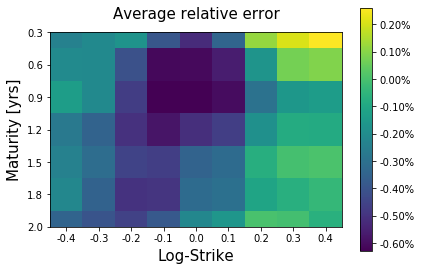

In [30]:
import matplotlib.ticker as mtick

# plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,1,1)
err = np.mean(100*((X_sample-prediction)/prediction),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(K)-1,len(K)))
ax.set_xticklabels(strikeslabel)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Log-Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity [yrs]",fontsize=15,labelpad=5)

# ax=plt.subplot(1,3,2)
# err = 100*np.std(((X_sample-prediction)/prediction),axis = 0)
# plt.title("Std relative error",fontsize=15,y=1.04)
# plt.imshow(err.reshape(maturities_dim,strikes_dim))
# plt.colorbar()
# ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikeslabel)
# ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
# ax.set_yticklabels(maturities)
# plt.xlabel("Strike",fontsize=15,labelpad=5)
# plt.ylabel("Maturity",fontsize=15,labelpad=5)

# ax=plt.subplot(1,3,3)
# err = 100*np.max(((X_sample-prediction)/prediction),axis = 0)
# plt.title("Maximum relative error",fontsize=15,y=1.04)
# plt.imshow(err.reshape(maturities_dim,strikes_dim))
# plt.colorbar()
# ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikeslabel)
# ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
# ax.set_yticklabels(maturities)
# plt.xlabel("Strike",fontsize=15,labelpad=5)
# plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.tight_layout()
plt.savefig('rBergomiNNErrors.png', dpi=300)
plt.show()

[ 0.10806274 -0.27041919  2.555509   -0.55804774]


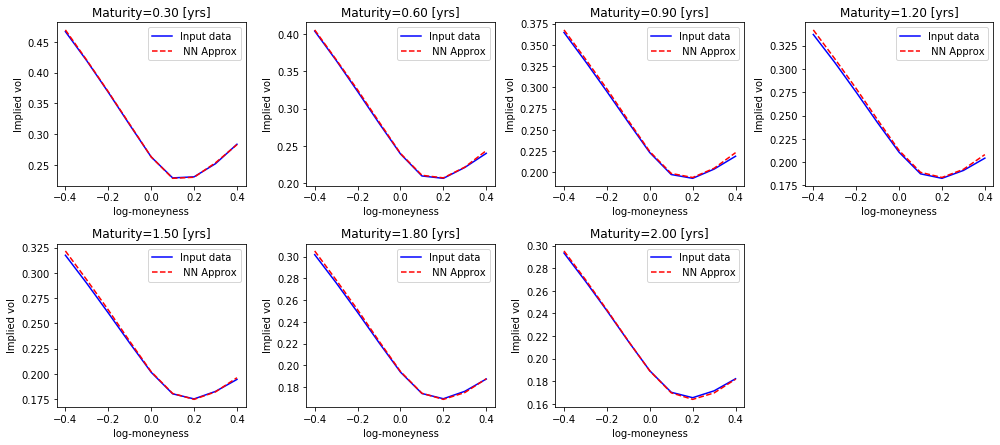

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 154
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
print(scale.inverse_transform(y_sample))

prediction=xinversetransform(modelGEN.predict(y_sample.reshape(1,4))[0])
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f [yrs]"%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.savefig('NN_compare.png', dpi=300)
plt.show()
